# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 2 модели похожую по архитектуре на модель из ULMFit для задачи классификации текста (датасет - lenta_40k )
В моделях должно быть как минимум два рекуррентных слоя, а финальный вектор для классификации составляться из последнего состояния RNN (так делалось в семинаре), а также AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояния и результаты пулинга). В первой модели используйте обычные слои, а во второй Bidirectional. Рассчитайте по классовую точность/полноту/f-меру для каждой из модели (результаты не должны быть совсем близкие к нулю после обучения на хотя бы нескольких эпохах). 

In [7]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.5.0


In [8]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
# from IPython.display import Image
# from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report

In [41]:
data = pd.read_csv('/kaggle/input/lenta-40k-csv-zip/lenta_40k.csv')

In [42]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [43]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [44]:
len(vocab)

354611

In [45]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [46]:
len(filtered_vocab)

24091

In [47]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [48]:
id2word = {i:word for word, i in word2id.items()}

In [49]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [50]:
MEAN_LEN = np.median([len(x) for x in X])

In [51]:
MAX_LEN = int(MEAN_LEN + 30)

In [52]:
# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [53]:
X.shape

(44356, 200)

In [54]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [55]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [56]:
len(label2id)

19

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [9]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=5, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

Модель 1:

In [23]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

rnn = keras.layers.LSTM(128, return_sequences=True)(embeddings)
rnn = keras.layers.LSTM(128, return_sequences=True)(rnn)

avg_pool = keras.layers.GlobalAveragePooling1D()(rnn)
max_pool = keras.layers.GlobalMaxPooling1D()(rnn)
last_state = keras.layers.Lambda(lambda x: x[:, -1, :])(rnn)

hidden = keras.layers.concatenate([last_state, avg_pool, max_pool])
outputs = keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 100)       │      2,409,300 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 200, 128)       │        117,248 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 200, 128)       │        131,584 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128)            │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ lstm_1[0][0]           │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ lstm_1[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 384)            │              0 │ lambda[0][0],          │
│                           │                        │                │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 19)             │          7,315 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,665,447 (10.17 MB)

 Trainable params: 2,665,447 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=100,
         callbacks=[checkpoint, early_stop])

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - loss: 2.7382 - rec@prec: 2.5253e-06
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 578ms/step - loss: 2.7301 - rec@prec: 2.4155e-06 - val_loss: 2.3167 - val_rec@prec: 0.0000e+00
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - loss: 2.2447 - rec@prec: 1.9058e-05
Epoch 2: val_rec@prec did not improve from 0.00000
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 583ms/step - loss: 2.2411 - rec@prec: 1.8229e-05 - val_loss: 1.9430 - val_rec@prec: 0.0000e+00
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - loss: 1.8280 - rec@prec: 0.0028
Epoch 3: val_rec@prec improved from 0.00000 to 0.12128, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 588ms/step - loss: 1.8257 - rec@prec: 0.0033 - val_loss: 1.6604 - val_rec@prec: 0.1213
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - loss: 1.5477 - rec@prec: 0.1634
Epoch 4: val_rec@prec did not improve from 0.121

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


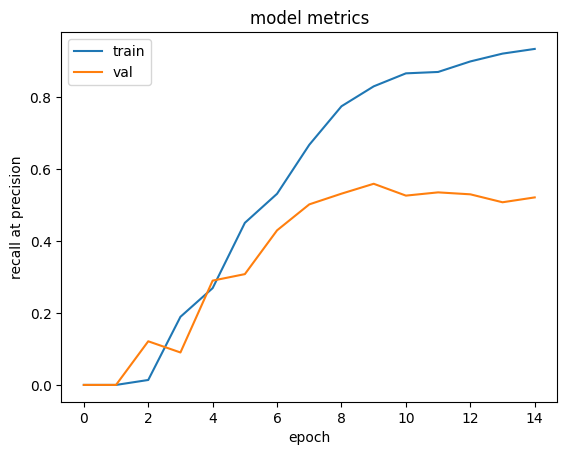

In [26]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
pred = model.predict(X_valid).argmax(axis=1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step


In [29]:
y_valid_report = y_valid.argmax(axis=1)

In [30]:
print(classification_report(y_valid_report, pred, labels=list(id2label.keys()),
                            target_names=list(id2label.values()),
                            zero_division=0))

                   precision    recall  f1-score   support

            Спорт       0.93      0.93      0.93       195
Силовые структуры       0.03      0.02      0.02        60
           Бизнес       0.06      0.05      0.05        22
      Путешествия       0.00      0.00      0.00        21
  Наука и техника       0.67      0.70      0.69       160
         Культура       0.83      0.69      0.76       159
      Бывший СССР       0.59      0.56      0.57       159
              Дом       0.62      0.73      0.67        66
         Ценности       0.32      0.48      0.39        23
              Мир       0.74      0.75      0.74       410
   69-я параллель       0.00      0.00      0.00         4
    Культпросвет        0.00      0.00      0.00         1
   Интернет и СМИ       0.30      0.33      0.31       132
           Россия       0.64      0.76      0.70       481
         Из жизни       0.28      0.23      0.25        84
        Экономика       0.81      0.70      0.75       

Модель 2 (Bidirectional):

In [59]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

rnn = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
rnn = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(rnn)

avg_pool = keras.layers.GlobalAveragePooling1D()(rnn)
max_pool = keras.layers.GlobalMaxPooling1D()(rnn)
last_state = keras.layers.Lambda(lambda x: x[:, -1, :])(rnn)

hidden = keras.layers.concatenate([last_state, avg_pool, max_pool])
outputs = keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model_bi = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
model_bi.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [60]:
model_bi.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 200, 100)       │      2,409,300 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 200, 256)       │        234,496 │ embedding_3[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 200, 256)       │        394,240 │ bidirectional_4[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 256)            │              0 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 256)            │              0 │ bidirectional_5[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 256)            │              0 │ bidirectional_5[0][0]  │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 768)            │              0 │ lambda_3[0][0],        │
│ (Concatenate)             │                        │                │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 19)             │         14,611 │ concatenate_3[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,052,647 (11.64 MB)

 Trainable params: 3,052,647 (11.64 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model_bi.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=100,
         callbacks=[checkpoint, early_stop])

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.6715 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 2.6634 - rec@prec: 0.0000e+00 - val_loss: 2.2165 - val_rec@prec: 0.0000e+00
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.1456 - rec@prec: 0.0000e+00
Epoch 2: val_rec@prec did not improve from 0.00000
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 2.1435 - rec@prec: 0.0000e+00 - val_loss: 1.9650 - val_rec@prec: 0.0000e+00
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.8878 - rec@prec: 0.0020
Epoch 3: val_rec@prec improved from 0.00000 to 0.02525, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 1.8849 - rec@prec: 0.0022 - val_loss: 1.7611 - val_rec@prec: 0.0252
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.5527 - rec@prec: 0.1301
Epoch 4: val_rec@prec improved from 0.02525 to 0.25518, saving model 

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


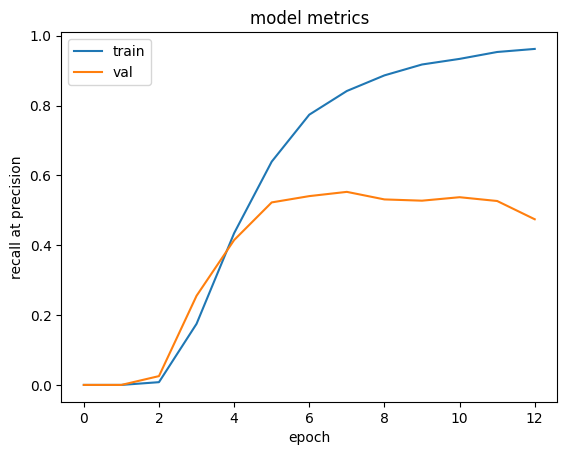

In [62]:
print(model_bi.history.history.keys())
# summarize history for accuracy
plt.plot(model_bi.history.history['rec@prec'])
plt.plot(model_bi.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [63]:
pred_bi = model_bi.predict(X_valid).argmax(axis=1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 559ms/step


In [64]:
y_valid_report_bi = y_valid.argmax(axis=1)

In [65]:
print(classification_report(y_valid_report_bi, pred_bi, labels=list(id2label.keys()),
                            target_names=list(id2label.values()),
                            zero_division=0))

                   precision    recall  f1-score   support

            Спорт       0.92      0.94      0.93       195
Силовые структуры       0.33      0.27      0.30        60
           Бизнес       0.20      0.09      0.13        22
      Путешествия       0.10      0.10      0.10        21
  Наука и техника       0.63      0.73      0.67       160
         Культура       0.74      0.76      0.75       159
      Бывший СССР       0.56      0.64      0.60       159
              Дом       0.81      0.59      0.68        66
         Ценности       0.67      0.61      0.64        23
              Мир       0.65      0.77      0.70       410
   69-я параллель       0.00      0.00      0.00         4
    Культпросвет        0.00      0.00      0.00         1
   Интернет и СМИ       0.40      0.45      0.42       132
           Россия       0.72      0.66      0.69       481
         Из жизни       0.30      0.29      0.29        84
        Экономика       0.85      0.64      0.73       

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите и сравните 3 модели:  
1) модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM 
2) модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать 
3) модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг



Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [63]:
from datasets import load_dataset

In [64]:
dataset = load_dataset("tner/wikiann", 'ru')

In [65]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
})

In [66]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [67]:
# тут словарь не очень большой и тут нужно предсказывать тэги для всех слов
# поэтому не будем фильтровать словарь
len(vocab)

36015

In [68]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [69]:
id2word = {i:word for word, i in word2id.items()}

In [70]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [71]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [72]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [73]:
label2id = {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6,
    "PAD": 7
}
id2labels = {v:k for k,v in label2id.items()} 

In [74]:
y = keras.preprocessing.sequence.pad_sequences(dataset['train']['tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = keras.preprocessing.sequence.pad_sequences(dataset['test']['tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [75]:
X.shape, X_test.shape

((20000, 54), (10000, 54))

In [76]:
y.shape, y_test.shape

((20000, 54), (10000, 54))

Модель 1 (GRU + LSTM):

In [23]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

gru = keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm = keras.layers.LSTM(128, return_sequences=True)(gru)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model_1 = keras.Model(inputs=inputs, outputs=outputs)

model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [25]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 54)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 54, 100)             │       3,601,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 54, 128)             │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 54, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 54, 8)               │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,822,636 (14.58 MB)

 Trainable params: 3,822,636 (14.58 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model_1.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=10)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.9738 - loss: 0.0773 - val_accuracy: 0.9643 - val_loss: 0.1035
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.9882 - loss: 0.0362 - val_accuracy: 0.9650 - val_loss: 0.1099
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step - accuracy: 0.9940 - loss: 0.0194 - val_accuracy: 0.9672 - val_loss: 0.1170
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.9967 - loss: 0.0124 - val_accuracy: 0.9675 - val_loss: 0.1210
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.9975 - loss: 0.0090 - val_accuracy: 0.9700 - val_loss: 0.1196
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 202ms/step - accuracy: 0.9983 - loss: 0.0069 - val_accuracy: 0.9699 - val_loss: 0.1274
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 0.9704 - val_loss: 0.1248
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.9987 - loss: 0

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


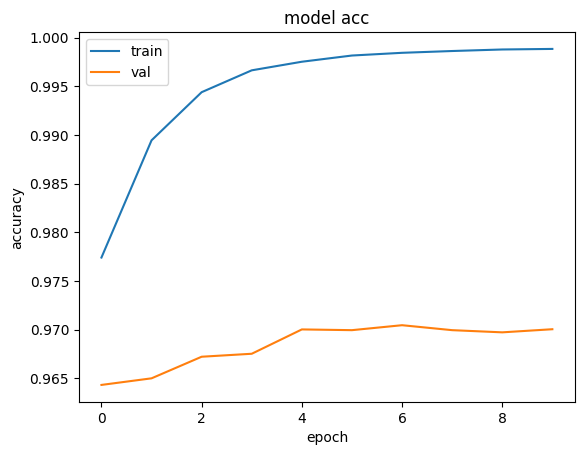

In [28]:
print(model_1.history.history.keys())
plt.plot(model_1.history.history['accuracy'])
plt.plot(model_1.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
pred_1 = model_1.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step


In [30]:
print(classification_report(y_test.reshape(-1), pred_1.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.60      0.66      0.63      4560
       B-ORG       0.36      0.72      0.48      4074
       B-PER       0.48      0.31      0.38      3542
       I-LOC       0.71      0.55      0.62      3060
       I-ORG       0.69      0.75      0.72      8008
       I-PER       0.92      0.50      0.65      7544
           O       0.90      0.90      0.90     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.71      0.67      0.67    540000
weighted avg       0.97      0.97      0.97    540000



Модель 2 (Residual):

In [95]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=128)(inputs)

rnn1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
rnn2 = keras.layers.LSTM(128, return_sequences=True)(rnn1)
rnn2_res = keras.layers.Add()([rnn2, embeddings])

rnn3 = keras.layers.LSTM(128, return_sequences=True)(rnn2_res)
rnn3_res = keras.layers.Add()([rnn3, embeddings])

outputs = keras.layers.Dense(len(label2id), activation='softmax')(rnn3_res)

model_2 = keras.Model(inputs=inputs, outputs=outputs)

model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [96]:
model_2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 54)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 54, 128)        │      4,610,176 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_13 (LSTM)            │ (None, 54, 128)        │        131,584 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_14 (LSTM)            │ (None, 54, 128)        │        131,584 │ lstm_13[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 54, 128)        │              0 │ lstm_14[0][0],         │
│                           │                        │                │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_15 (LSTM)            │ (None, 54, 128)        │        131,584 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 54, 128)        │              0 │ lstm_15[0][0],         │
│                           │                        │                │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 54, 8)          │          1,032 │ add_4[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,005,960 (19.10 MB)

 Trainable params: 5,005,960 (19.10 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
model_2.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=10)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 276ms/step - accuracy: 0.8690 - loss: 0.5579 - val_accuracy: 0.9491 - val_loss: 0.1739
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 275ms/step - accuracy: 0.9549 - loss: 0.1479 - val_accuracy: 0.9706 - val_loss: 0.0940
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 272ms/step - accuracy: 0.9797 - loss: 0.0662 - val_accuracy: 0.9764 - val_loss: 0.0730
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 275ms/step - accuracy: 0.9914 - loss: 0.0325 - val_accuracy: 0.9733 - val_loss: 0.0740
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.9961 - loss: 0.0173 - val_accuracy: 0.9735 - val_loss: 0.0814
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 276ms/step - accuracy: 0.9977 - loss: 0.0102 - val_accuracy: 0.9726 - val_loss: 0.0891
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 274ms/step - accuracy: 0.9984 - loss: 0.0071 - val_accuracy: 0.9739 - val_loss: 0.0925
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.9987 - loss: 0

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


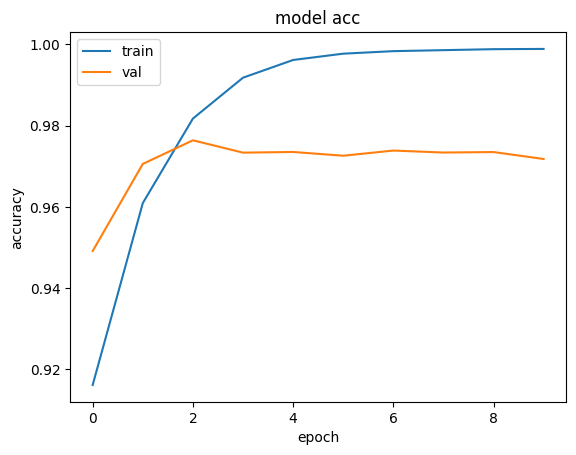

In [98]:
print(model_2.history.history.keys())
plt.plot(model_2.history.history['accuracy'])
plt.plot(model_2.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [99]:
pred_2 = model_2.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step


In [100]:
print(classification_report(y_test.reshape(-1), pred_2.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.77      0.58      0.66      4560
       B-ORG       0.46      0.65      0.54      4074
       B-PER       0.52      0.31      0.39      3542
       I-LOC       0.82      0.55      0.66      3060
       I-ORG       0.55      0.77      0.64      8008
       I-PER       0.92      0.51      0.65      7544
           O       0.89      0.94      0.91     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.74      0.66      0.68    540000
weighted avg       0.97      0.97      0.97    540000



Модель 3 (CNN + RNN):

In [86]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

conv1 = keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(embeddings)
conv2 = keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(conv1)
rnn1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(conv2)
rnn2 = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(rnn1)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(rnn2)

model_3 = keras.Model(inputs=inputs, outputs=outputs)

model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [87]:
model_3.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 54)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 54, 100)             │       3,601,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 54, 64)              │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 54, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 54, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 54, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 54, 8)               │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,129,452 (15.75 MB)

 Trainable params: 4,129,452 (15.75 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
model_3.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=10)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 69s 441ms/step - accuracy: 0.8831 - loss: 0.4817 - val_accuracy: 0.9641 - val_loss: 0.1081
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - accuracy: 0.9724 - loss: 0.0822 - val_accuracy: 0.9828 - val_loss: 0.0560
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 422ms/step - accuracy: 0.9924 - loss: 0.0240 - val_accuracy: 0.9833 - val_loss: 0.0543
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - accuracy: 0.9975 - loss: 0.0090 - val_accuracy: 0.9829 - val_loss: 0.0591
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 423ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.9812 - val_loss: 0.0726
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 425ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9818 - val_loss: 0.0787
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 421ms/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9811 - val_loss: 0.0836
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - accuracy: 0.9997 - loss: 0

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


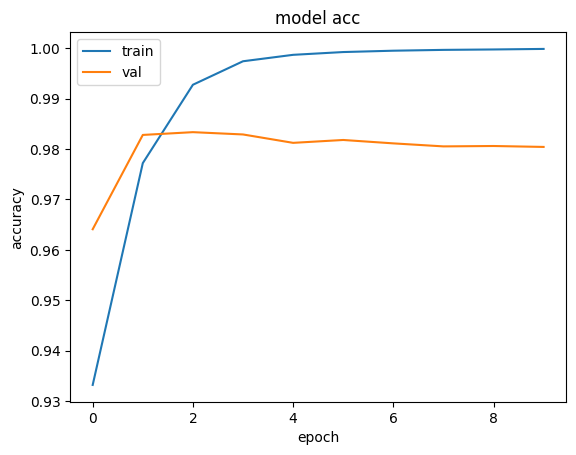

In [89]:
print(model_3.history.history.keys())
plt.plot(model_3.history.history['accuracy'])
plt.plot(model_3.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
pred_3 = model_3.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 189ms/step


In [91]:
print(classification_report(y_test.reshape(-1), pred_3.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.73      0.79      0.76      4560
       B-ORG       0.48      0.77      0.59      4074
       B-PER       0.91      0.64      0.76      3542
       I-LOC       0.80      0.77      0.78      3060
       I-ORG       0.73      0.81      0.77      8008
       I-PER       0.96      0.69      0.81      7544
           O       0.94      0.93      0.93     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.82      0.80      0.80    540000
weighted avg       0.98      0.98      0.98    540000



Метрики довольно неплохие, особенно у третьей модели

Предсказания:

In [32]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [33]:
sentence_1 = 'Ябу проводил его на холм к дому Оми.'
sentence_2 = 'Французский дизайнер Жан-Поль Готье представил новую коллекцию на Неделе моды в Париже.'
sentence_3 = 'Кристофер Нолан представил новый фильм ‘Оппенгеймер’ на Каннском кинофестивале.'

Модель 1:

In [34]:
label_seq(sentence_1, word2id, id2labels, MAX_LEN, model_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[('Ябу', 'B-ORG'),
 ('проводил', 'O'),
 ('его', 'O'),
 ('на', 'O'),
 ('холм', 'O'),
 ('к', 'O'),
 ('дому', 'O'),
 ('Оми', 'I-LOC'),
 ('.', 'O')]

In [35]:
label_seq(sentence_2, word2id, id2labels, MAX_LEN, model_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[('Французский', 'B-LOC'),
 ('дизайнер', 'O'),
 ('Жан', 'B-PER'),
 ('-', 'O'),
 ('Поль', 'B-PER'),
 ('Готье', 'B-PER'),
 ('представил', 'I-PER'),
 ('новую', 'I-PER'),
 ('коллекцию', 'O'),
 ('на', 'O'),
 ('Неделе', 'B-LOC'),
 ('моды', 'I-LOC'),
 ('в', 'O'),
 ('Париже', 'B-LOC'),
 ('.', 'O')]

In [36]:
label_seq(sentence_3, word2id, id2labels, MAX_LEN, model_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[('Кристофер', 'O'),
 ('Нолан', 'I-ORG'),
 ('представил', 'O'),
 ('новый', 'B-LOC'),
 ('фильм', 'I-ORG'),
 ('‘', 'I-ORG'),
 ('Оппенгеймер', 'I-ORG'),
 ('’', 'I-ORG'),
 ('на', 'O'),
 ('Каннском', 'O'),
 ('кинофестивале', 'I-ORG'),
 ('.', 'O')]

Модель 2:

In [101]:
label_seq(sentence_1, word2id, id2labels, MAX_LEN, model_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


[('Ябу', 'I-ORG'),
 ('проводил', 'O'),
 ('его', 'O'),
 ('на', 'O'),
 ('холм', 'O'),
 ('к', 'O'),
 ('дому', 'O'),
 ('Оми', 'B-LOC'),
 ('.', 'O')]

In [102]:
label_seq(sentence_2, word2id, id2labels, MAX_LEN, model_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[('Французский', 'B-PER'),
 ('дизайнер', 'O'),
 ('Жан', 'I-PER'),
 ('-', 'O'),
 ('Поль', 'B-LOC'),
 ('Готье', 'I-PER'),
 ('представил', 'I-PER'),
 ('новую', 'B-LOC'),
 ('коллекцию', 'O'),
 ('на', 'O'),
 ('Неделе', 'O'),
 ('моды', 'O'),
 ('в', 'O'),
 ('Париже', 'B-LOC'),
 ('.', 'O')]

In [103]:
label_seq(sentence_3, word2id, id2labels, MAX_LEN, model_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[('Кристофер', 'O'),
 ('Нолан', 'O'),
 ('представил', 'O'),
 ('новый', 'B-LOC'),
 ('фильм', 'I-ORG'),
 ('‘', 'I-ORG'),
 ('Оппенгеймер', 'I-ORG'),
 ('’', 'O'),
 ('на', 'O'),
 ('Каннском', 'O'),
 ('кинофестивале', 'O'),
 ('.', 'O')]

Модель 3:

In [92]:
label_seq(sentence_1, word2id, id2labels, MAX_LEN, model_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


[('Ябу', 'O'),
 ('проводил', 'O'),
 ('его', 'O'),
 ('на', 'O'),
 ('холм', 'O'),
 ('к', 'O'),
 ('дому', 'O'),
 ('Оми', 'I-ORG'),
 ('.', 'O')]

In [93]:
label_seq(sentence_2, word2id, id2labels, MAX_LEN, model_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


[('Французский', 'B-ORG'),
 ('дизайнер', 'I-ORG'),
 ('Жан', 'I-ORG'),
 ('-', 'O'),
 ('Поль', 'O'),
 ('Готье', 'O'),
 ('представил', 'O'),
 ('новую', 'O'),
 ('коллекцию', 'O'),
 ('на', 'O'),
 ('Неделе', 'O'),
 ('моды', 'O'),
 ('в', 'O'),
 ('Париже', 'B-LOC'),
 ('.', 'O')]

In [94]:
label_seq(sentence_3, word2id, id2labels, MAX_LEN, model_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


[('Кристофер', 'O'),
 ('Нолан', 'O'),
 ('представил', 'O'),
 ('новый', 'B-ORG'),
 ('фильм', 'I-ORG'),
 ('‘', 'I-ORG'),
 ('Оппенгеймер', 'I-ORG'),
 ('’', 'I-ORG'),
 ('на', 'O'),
 ('Каннском', 'B-ORG'),
 ('кинофестивале', 'I-ORG'),
 ('.', 'O')]

А вот распознавание именованных сущностей работает не очень